# Hyperparameter Tuning Using Feature Set 2

---

**Feature Set 2** includes:

- **Soil Moisture**
- **Temperature**
- **Soil Humidity**
- **Air temperature (C)**
- **Wind speed (Km/h)**
- **Pressure (KPa)**

The dataset used for this analysis is available [here](https://www.kaggle.com/datasets/nelakurthisudheer/dataset-for-predicting-watering-the-plants).

## Importing Libraries

Import necessary libraries and do basic set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc
)

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preparation and Feature Selection

In [2]:
df = pd.read_csv('soil_data.csv')
required_columns = ['Soil Moisture', 'Temperature', 'Soil Humidity', 'Air temperature (C)', 'Wind speed (Km/h)', 'Pressure (KPa)', 'Status']
df = df.dropna(subset=required_columns)
df['Status'] = df['Status'].map({'OFF': 0, 'ON': 1})

fs2 = ['Soil Moisture', 'Temperature', 'Soil Humidity', 'Air temperature (C)', 'Wind speed (Km/h)', 'Pressure (KPa)'] 

X = df[fs2]
y = df['Status']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Evaluation set size: {X_test.shape[0]} samples")

Training set size: 16796 samples
Evaluation set size: 7199 samples


## Random Forest

### Training Model

In [4]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Optional: If you decide to use SMOTE
USE_SMOTE = False  # Set to True if you want to apply SMOTE

def objective(trial):
    # Adjusted hyperparameter search space based on previous best results
    n_estimators = trial.suggest_int('n_estimators', 900, 1000)            # Focus around 974
    max_depth = trial.suggest_int('max_depth', 4, 10)                      # Lower values to reduce overfitting
    min_samples_split = trial.suggest_int('min_samples_split', 15, 25)     # Around 20
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 15, 25)       # Around 20
    max_features = trial.suggest_categorical('max_features', ['log2'])     # 'log2' was best
    bootstrap = trial.suggest_categorical('bootstrap', [True])             # True was best
    criterion = trial.suggest_categorical('criterion', ['entropy'])        # 'entropy' was best
    class_weight = trial.suggest_categorical('class_weight', ['balanced']) # 'balanced' was best

    # Initialize the classifier with current trial's hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    # Define cross-validation strategy with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Evaluate using cross-validated precision without SMOTE
    precision = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv,
        scoring='precision',
        n_jobs=-1
    ).mean()
    
    return precision

# Create a study object with MedianPruner for early stopping
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
study = optuna.create_study(direction='maximize', pruner=pruner)

# Optimize the objective function with adjusted search space
study.optimize(objective, n_trials=25, n_jobs=1, show_progress_bar=True)

# Get the best trial
best_trial = study.best_trial
best_params = best_trial.params
best_precision = best_trial.value

# Initialize the Random Forest classifier with best parameters
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    criterion=best_params['criterion'],
    class_weight=best_params['class_weight'],
    random_state=42,
    n_jobs=-1
)

# Create the final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', rf_best)
])

# Fit the best model on the entire training set
final_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = final_pipeline.predict(X_test)

# Calculate precision on the test set
test_precision = precision_score(y_test, y_pred, zero_division=0)

# Print the best parameters and best precision score from cross-validation
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Precision Score: {best_precision:.4f}")

# Print the precision score on the test set
print(f"Test Precision Score: {test_precision:.4f}")

[I 2024-11-18 21:59:37,578] A new study created in memory with name: no-name-5f8bee91-9e95-4124-b7e9-212998e4966d


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-11-18 21:59:44,810] Trial 0 finished with value: 0.7615563321082505 and parameters: {'n_estimators': 978, 'max_depth': 9, 'min_samples_split': 22, 'min_samples_leaf': 25, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7615563321082505.
[I 2024-11-18 21:59:48,945] Trial 1 finished with value: 0.7649852074418166 and parameters: {'n_estimators': 901, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7649852074418166.
[I 2024-11-18 21:59:53,941] Trial 2 finished with value: 0.7604460030941287 and parameters: {'n_estimators': 955, 'max_depth': 9, 'min_samples_split': 21, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7649852074418166.
[I 2024-11-18 21:59:58,159] Tri

### Training Evaluation

In [5]:
# make predictions on training set
y_train_pred_rf = final_pipeline.predict(X_train)

# calculate training evaluation metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf)
train_recall_rf = recall_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)

# display training metrics
print("Random Forest Training Performance Metrics:")
print(f"Accuracy : {train_accuracy_rf:.4f}")
print(f"Precision: {train_precision_rf:.4f}")
print(f"Recall   : {train_recall_rf:.4f}")
print(f"F1-Score : {train_f1_rf:.4f}")

Random Forest Training Performance Metrics:
Accuracy : 0.7285
Precision: 0.7755
Recall   : 0.7007
F1-Score : 0.7362


### Evaluation - Accuracy, Precision, Recall and F1-Score

In [6]:
# predict then evaluate
y_pred_rf = final_pipeline.predict(X_test)

# calc evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# display the metrics
print(f"Accuracy : {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall   : {recall_rf:.4f}")
print(f"F1-Score : {f1_rf:.4f}")

Accuracy : 0.7138
Precision: 0.7601
Recall   : 0.6878
F1-Score : 0.7221


### Confusion Matrix


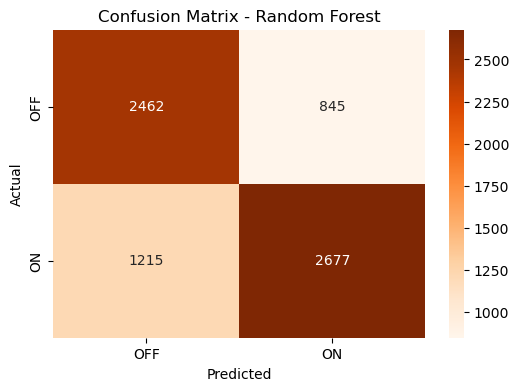

In [7]:
# gen  confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=['OFF', 'ON'], yticklabels=['OFF', 'ON'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

### Classification Reports

In [11]:
# Training set classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_train_pred_rf, target_names=['OFF', 'ON']))

# Testing set classification report
print("Classification Report - Testing Set:")
print(classification_report(y_test, y_pred_rf, target_names=['OFF', 'ON']))


Classification Report - Training Set:
              precision    recall  f1-score   support

         OFF       0.68      0.76      0.72      7715
          ON       0.78      0.70      0.74      9081

    accuracy                           0.73     16796
   macro avg       0.73      0.73      0.73     16796
weighted avg       0.73      0.73      0.73     16796

Classification Report - Testing Set:
              precision    recall  f1-score   support

         OFF       0.67      0.74      0.71      3307
          ON       0.76      0.69      0.72      3892

    accuracy                           0.71      7199
   macro avg       0.71      0.72      0.71      7199
weighted avg       0.72      0.71      0.71      7199



### ROC Curve

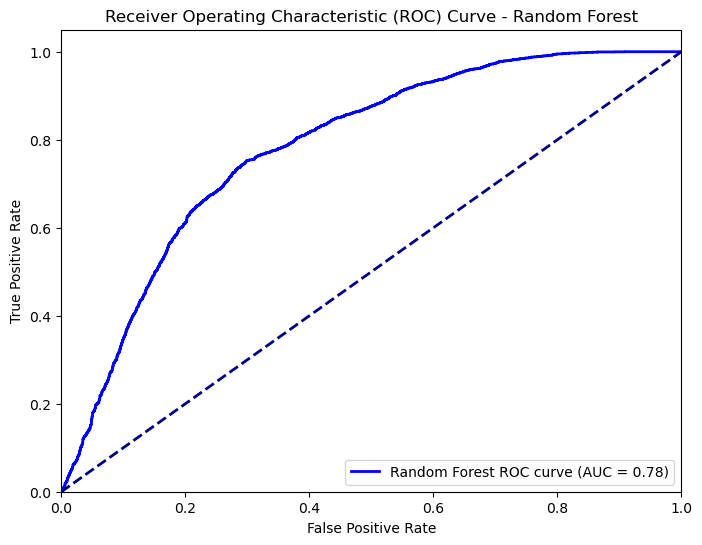

In [9]:
# Predict probabilities for ROC curve
y_prob_rf = final_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve

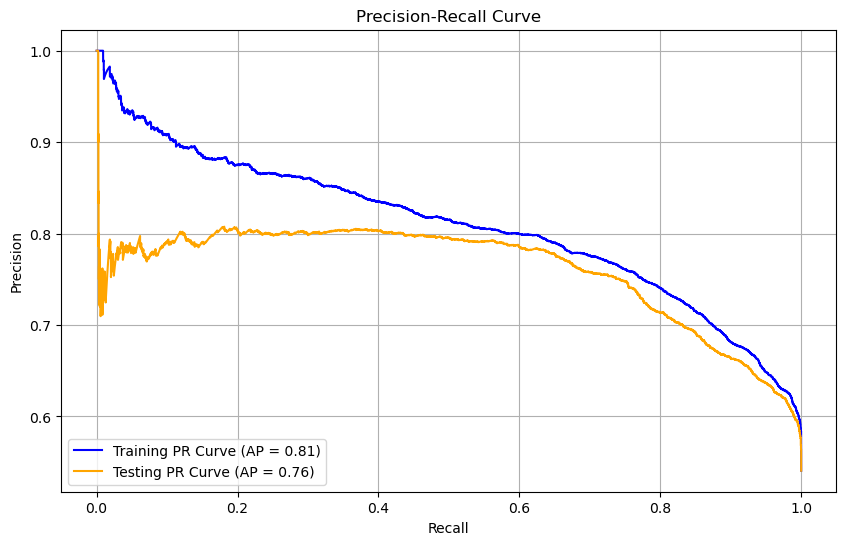

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get probabilities for the positive class
y_prob_rf_train = final_pipeline.predict_proba(X_train)[:, 1]
y_prob_rf_test = final_pipeline.predict_proba(X_test)[:, 1]

# Precision-Recall curve for the training set
precision_train, recall_train, _ = precision_recall_curve(y_train, y_prob_rf_train)
average_precision_train = average_precision_score(y_train, y_prob_rf_train)

# Precision-Recall curve for the testing set
precision_test, recall_test, _ = precision_recall_curve(y_test, y_prob_rf_test)
average_precision_test = average_precision_score(y_test, y_prob_rf_test)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, label=f'Training PR Curve (AP = {average_precision_train:.2f})', color='blue')
plt.plot(recall_test, precision_test, label=f'Testing PR Curve (AP = {average_precision_test:.2f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


In [13]:
# Add predicted probabilities and true values to the test DataFrame
df_test = X_test.copy()
df_test['True Status'] = y_test
df_test['Predicted Status'] = y_pred_rf
df_test['Prediction Probability'] = y_prob_rf_test

# Filter correctly predicted samples
correct_preds = df_test[df_test['True Status'] == df_test['Predicted Status']]

# Sort by prediction probability (descending)
top_correct_preds = correct_preds.sort_values(by='Prediction Probability', ascending=False).head(10)

# Print the top occurrences
print("Top 10 Correctly Predicted Samples:")
print(top_correct_preds)


Top 10 Correctly Predicted Samples:
       Soil Moisture  Temperature  Soil Humidity  Air temperature (C)  \
5061               8           43             69                37.82   
22025              9           36             68                33.82   
437               17           33             69                34.86   
11715             10           42             69                26.39   
17441             17           39             65                37.95   
4729               8           43             68                34.84   
6798               6           28             66                38.86   
1628              14           42             69                31.72   
15773             35           41             65                23.66   
23723              9           35             65                21.34   

       Wind speed (Km/h)  Pressure (KPa)  True Status  Predicted Status  \
5061               23.02          101.33            1                 1   
22025     

In [14]:
# Add true labels, predictions, and probabilities to the test DataFrame
df_test = X_test.copy()
df_test['True Status'] = y_test
df_test['Predicted Status'] = y_pred_rf
df_test['Prediction Probability'] = y_prob_rf_test

# Identify false positives (FP) and false negatives (FN)
false_positives = df_test[(df_test['True Status'] == 0) & (df_test['Predicted Status'] == 1)]
false_negatives = df_test[(df_test['True Status'] == 1) & (df_test['Predicted Status'] == 0)]

# Print the false positives
print("False Positives (Predicted ON, True OFF):")
print(false_positives)

# Print the false negatives
print("\nFalse Negatives (Predicted OFF, True ON):")
print(false_negatives)


False Positives (Predicted ON, True OFF):
       Soil Moisture  Temperature  Soil Humidity  Air temperature (C)  \
1155              58           40             44                21.53   
26125             43           42             23                25.82   
10294             45           32             46                22.83   
7924              68           44             45                26.54   
19485             15           26             57                26.65   
...              ...          ...            ...                  ...   
6043              13           18             44                19.24   
12555             33           25             41                36.50   
12433             58           24             42                18.45   
8269              42           45             26                23.29   
1169              55           30             63                19.97   

       Wind speed (Km/h)  Pressure (KPa)  True Status  Predicted Status  \
1155  

In [15]:
# Add true labels, predictions, and probabilities to the test DataFrame
df_test = X_test.copy()
df_test['True Status'] = y_test
df_test['Predicted Status'] = y_pred_rf
df_test['Prediction Probability'] = y_prob_rf_test

# Identify false positives (FP) and false negatives (FN)
false_positives = df_test[(df_test['True Status'] == 0) & (df_test['Predicted Status'] == 1)]
false_negatives = df_test[(df_test['True Status'] == 1) & (df_test['Predicted Status'] == 0)]

# Print the false positives
print("False Positives (Predicted ON, True OFF):")
print(false_positives)

# Print the false negatives
print("\nFalse Negatives (Predicted OFF, True ON):")
print(false_negatives)


False Positives (Predicted ON, True OFF):
       Soil Moisture  Temperature  Soil Humidity  Air temperature (C)  \
1155              58           40             44                21.53   
26125             43           42             23                25.82   
10294             45           32             46                22.83   
7924              68           44             45                26.54   
19485             15           26             57                26.65   
...              ...          ...            ...                  ...   
6043              13           18             44                19.24   
12555             33           25             41                36.50   
12433             58           24             42                18.45   
8269              42           45             26                23.29   
1169              55           30             63                19.97   

       Wind speed (Km/h)  Pressure (KPa)  True Status  Predicted Status  \
1155  